### import des bibliothèques

In [112]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

### import du dataset

In [2]:
df = pd.read_csv('..\data_final\dataset_without_outliers.csv', index_col=0)
df1 = pd.read_csv('..\data_final\dataset_with_outliers.csv', index_col=0)

In [4]:
def prepare(df):
    df['casting_score_mean'] = df['casting_score_mean'].map(int)
    df.drop(columns = ['titre', 'realisateur', 'casting', 'compagnies_production', 
        'recette', 'director_score_mean', 'director_score_med',
        'director_score_min', 'director_score_max',
        'compagnies_score_mean', 'compagnies_score_med', 'compagnies_score_min',
        'compagnies_score_max'], inplace = True)
    return df

prepare(df)
prepare(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,TV Movie,saison,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum
0,40000000,110,3,1,0,0,0,0,0,0,...,0,2,324.592525,79,1,0,0,38,27,135
1,2000000,100,1,1,1,0,0,0,0,0,...,0,2,-88.000000,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,0,0,320.450925,459,7,0,0,100,128,81
3,4000000,80,1,1,0,0,0,0,0,0,...,0,3,148.456700,0,0,0,0,0,0,0
4,12000000,95,1,0,1,0,0,0,1,0,...,0,0,-92.608333,5,0,0,0,5,4,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0,1,0.000000,0,0,0,0,0,0,0
7852,300,0,1,0,1,0,0,0,0,0,...,0,1,-99.666667,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,0,3,25.000000,0,0,0,0,0,0,0
7854,75,75,1,0,0,0,0,0,0,0,...,0,0,0.000000,0,0,0,0,0,0,0


### Librairies pour la prédiction

In [5]:
from random import shuffle
from sklearn import tree, preprocessing, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score


### Création de catégorie de bénéfice global

In [6]:
df.describe()['benefice global']

count     4695.000000
mean       214.418103
std        562.548423
min        -98.965390
25%        -29.184778
50%         77.704300
75%        260.048464
max      12400.282100
Name: benefice global, dtype: float64

In [10]:
def construction_tranche(df):
    df['tranche benef'] = 0
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.25), 'tranche benef'] = 1
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.5), 'tranche benef'] = 2
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.75), 'tranche benef'] = 3
    df['tranche benef binaire'] = 0
    df.loc[df['benefice global'] > 0, 'tranche benef binaire'] = 1
    df['tranche benef binaire'].value_counts()
    return df

construction_tranche(df)
construction_tranche(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum,tranche benef,tranche benef binaire
0,40000000,110,3,1,0,0,0,0,0,0,...,324.592525,79,1,0,0,38,27,135,2,1
1,2000000,100,1,1,1,0,0,0,0,0,...,-88.000000,0,0,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,320.450925,459,7,0,0,100,128,81,2,1
3,4000000,80,1,1,0,0,0,0,0,0,...,148.456700,0,0,0,0,0,0,0,2,1
4,12000000,95,1,0,1,0,0,0,1,0,...,-92.608333,5,0,0,0,5,4,54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0
7852,300,0,1,0,1,0,0,0,0,0,...,-99.666667,0,0,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,25.000000,0,0,0,0,0,0,0,1,1
7854,75,75,1,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0


In [9]:
df['tranche benef'].value_counts()

3    1174
0    1174
2    1174
1    1173
Name: tranche benef, dtype: int64

### creation d'un train et d'un texte

In [20]:
def X_and_Y(df):
    X = df.drop(columns = ['tranche benef', 'benefice global', 'tranche benef binaire'])
    Y = df['tranche benef']
    Y_bin = df['tranche benef binaire']
    return X, Y, Y_bin

division du dataset en un train et un test

In [47]:
def train_test(df):
    X, Y, Y_bin = X_and_Y(df)
    TRAINING_SET_RATIO = 0.9    
    ind = [i for i in range(df.shape[0])]
    random.seed(4)
    random.shuffle(ind)
    X_train=X.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_train=Y.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_bin_train=Y_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    X_test=X.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_test=Y.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_bin_test=Y_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    return X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test

### méthode du Decision Tree Classifier 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


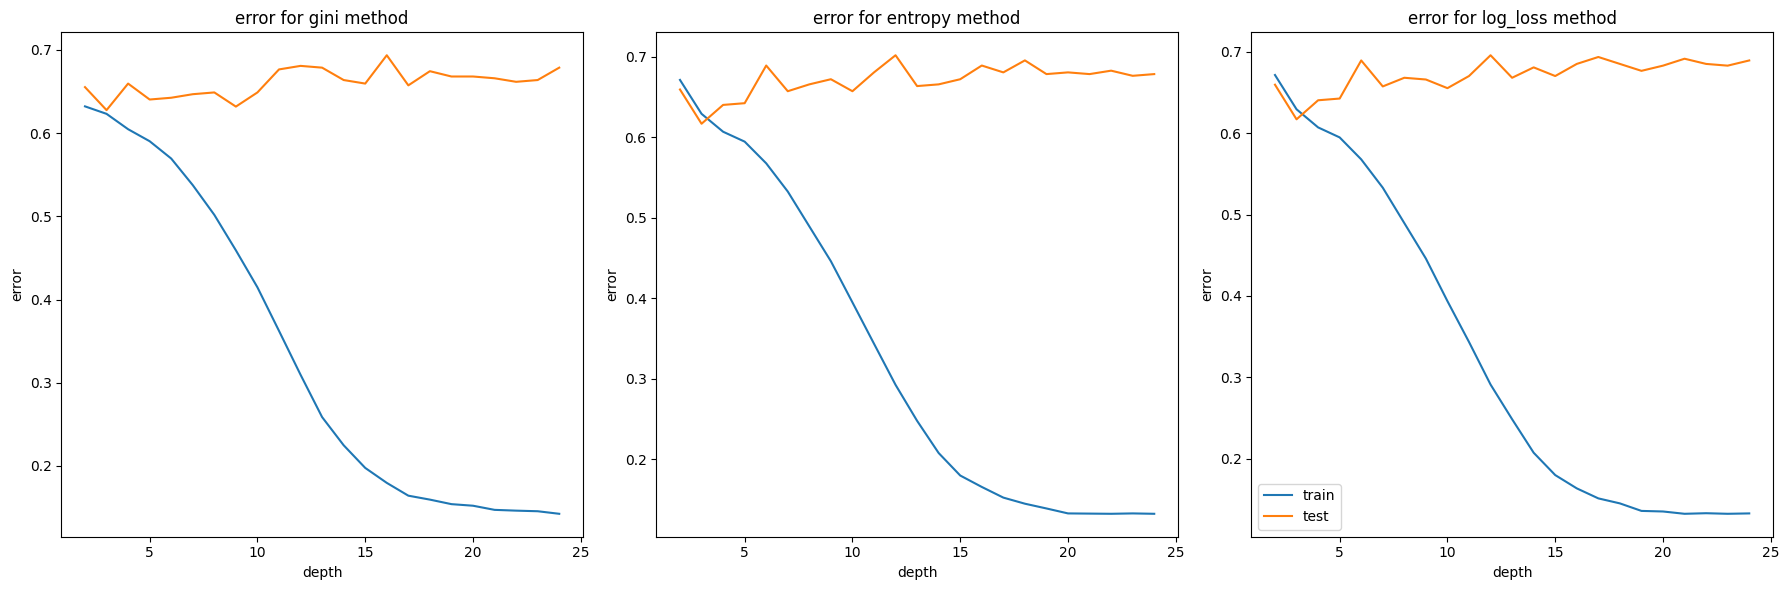

In [49]:
def decision_tree(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    train_scores_dico = {}
    test_scores_dico = {}
    criteria = ["gini", "entropy", "log_loss"]
    for criterion in ["gini", "entropy", "log_loss"]:
        train_scores = []
        test_scores = []
        depths = [i for i in range(2,25)]
        for depth in depths:
            clf = tree.DecisionTreeClassifier(criterion = criterion , max_depth = depth, min_samples_split = 2, min_samples_leaf = 2)
            clf = clf.fit(X_train, Y_train)
            train_score = clf.score(X_train, Y_train)
            train_scores.append(1 - train_score)
            test_score = clf.score(X_test,Y_test)
            test_scores.append(1 - test_score)
        train_scores_dico[criterion] = train_scores
        test_scores_dico[criterion] = test_scores

    fig, ax = plt.subplots(1,3, figsize = (18,6))
    for i, criterion in enumerate(criteria):
        ax[i].set_title(f'error for {criterion} method')
        ax[i].plot(depths, train_scores_dico[criterion], label=f"train")
        ax[i].plot(depths, test_scores_dico[criterion], label=f"test")
        ax[i].set_xlabel("depth")
        ax[i].set_ylabel("error")
        plt.legend()

    fig.tight_layout()
    plt.show()

decision_tree(df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


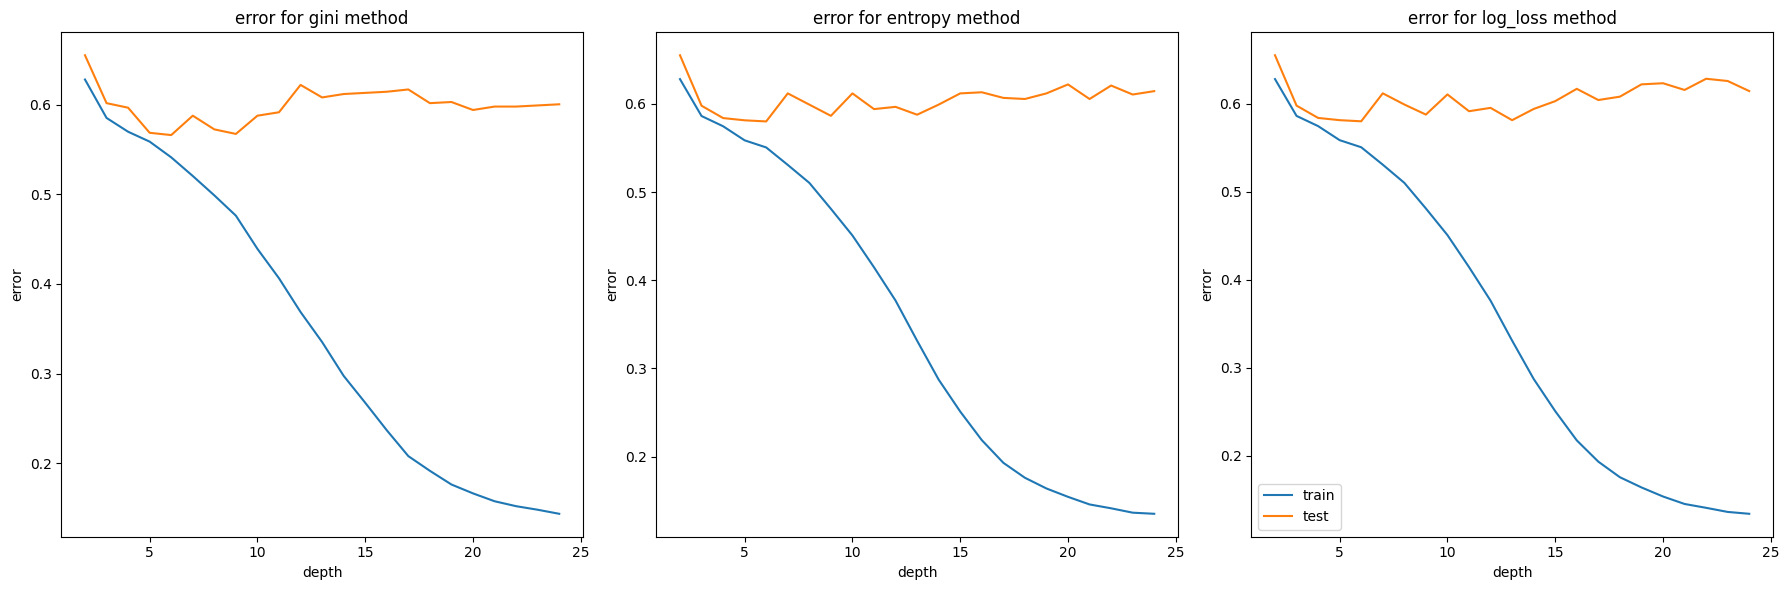

In [50]:
decision_tree(df1)

In [51]:
def scores_decision_tree(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    clf = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 2, min_samples_leaf = 2)
    clf.fit(X_train, Y_train)
    Y_pred_test = clf.predict(X_test)
    print(confusion_matrix(Y_test, Y_pred_test, labels=[0,1,2,3]))
    print(classification_report(Y_test, Y_pred_test, digits = 4))

In [52]:
scores_decision_tree(df)

[[65 13 29 10]
 [41 11 43 19]
 [33  5 57 21]
 [28  7 52 36]]
              precision    recall  f1-score   support

           0     0.3892    0.5556    0.4577       117
           1     0.3056    0.0965    0.1467       114
           2     0.3149    0.4914    0.3838       116
           3     0.4186    0.2927    0.3445       123

    accuracy                         0.3596       470
   macro avg     0.3571    0.3590    0.3332       470
weighted avg     0.3583    0.3596    0.3344       470



In [53]:
scores_decision_tree(df1)

[[ 64  26  69  34]
 [ 51  48  74  43]
 [ 31   9 108  35]
 [ 11  11  53 119]]
              precision    recall  f1-score   support

           0     0.4076    0.3316    0.3657       193
           1     0.5106    0.2222    0.3097       216
           2     0.3553    0.5902    0.4435       183
           3     0.5152    0.6134    0.5600       194

    accuracy                         0.4313       786
   macro avg     0.4472    0.4393    0.4197       786
weighted avg     0.4503    0.4313    0.4164       786



In [54]:
def decision_tree_bin(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    train_scores_dico = {}
    test_scores_dico = {}
    criteria = ["gini", "entropy", "log_loss"]
    for criterion in ["gini", "entropy", "log_loss"]:
        train_scores = []
        test_scores = []
        depths = [i for i in range(2,25)]
        for depth in depths:
            clf = tree.DecisionTreeClassifier(criterion = criterion , max_depth = depth, min_samples_split = 2, min_samples_leaf = 2)
            clf = clf.fit(X_train, Y_bin_train)
            train_score = clf.score(X_train, Y_bin_train)
            train_scores.append(1 - train_score)
            test_score = clf.score(X_test,Y_bin_test)
            test_scores.append(1 - test_score)
        train_scores_dico[criterion] = train_scores
        test_scores_dico[criterion] = test_scores

    fig, ax = plt.subplots(1,3, figsize = (18,6))
    for i, criterion in enumerate(criteria):
        ax[i].set_title(f'error for {criterion} method')
        ax[i].plot(depths, train_scores_dico[criterion], label=f"train")
        ax[i].plot(depths, test_scores_dico[criterion], label=f"test")
        ax[i].set_xlabel("depth")
        ax[i].set_ylabel("error")
        plt.legend()

    fig.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


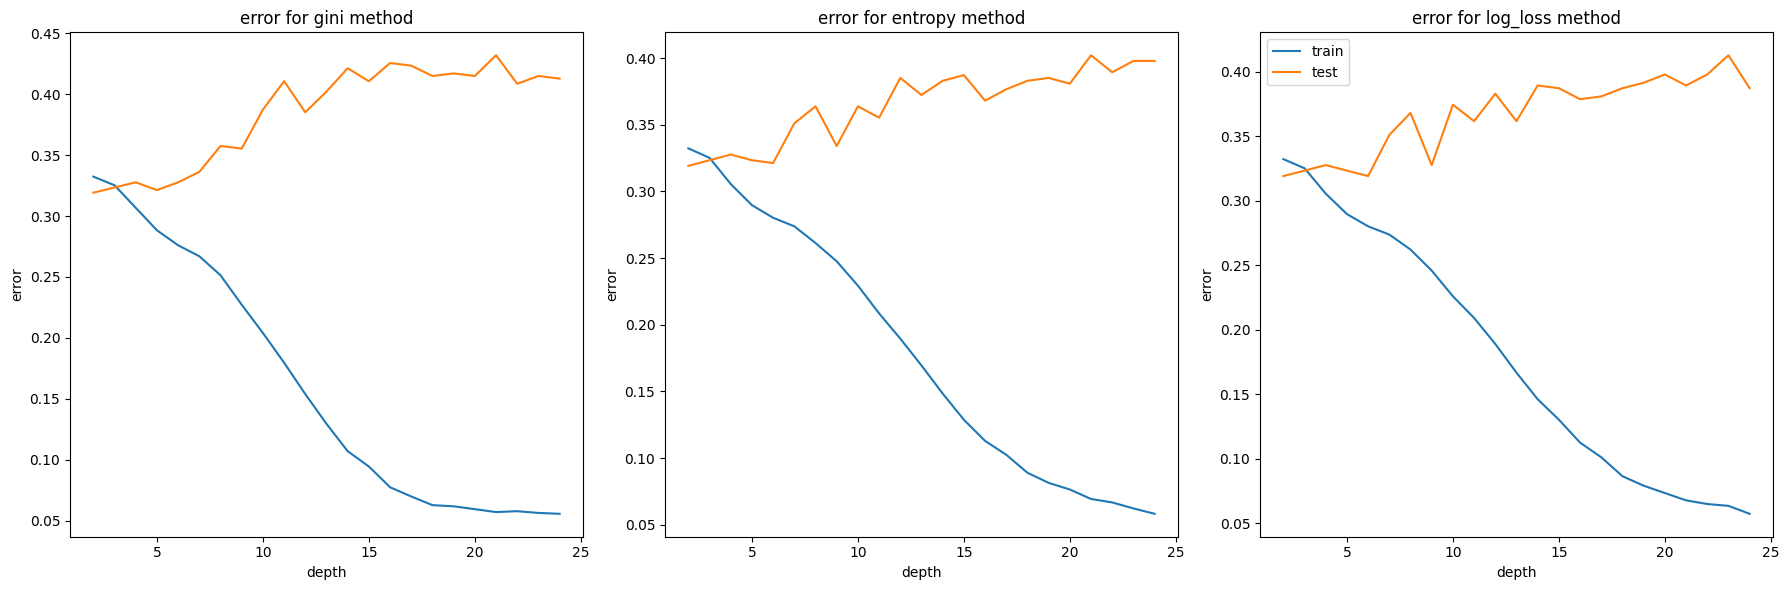

In [56]:
decision_tree_bin(df)

In [57]:
def scores_decision_tree_bin(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    clf = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 2, min_samples_leaf = 2)
    clf.fit(X_train, Y_bin_train)
    Y_pred_test = clf.predict(X_test)
    print(confusion_matrix(Y_bin_test, Y_pred_test, labels=[0,1]))
    print(classification_report(Y_bin_test, Y_pred_test, digits = 4))

In [58]:
scores_decision_tree_bin(df)

[[ 46 104]
 [ 48 272]]
              precision    recall  f1-score   support

           0     0.4894    0.3067    0.3770       150
           1     0.7234    0.8500    0.7816       320

    accuracy                         0.6766       470
   macro avg     0.6064    0.5783    0.5793       470
weighted avg     0.6487    0.6766    0.6525       470



### méthode KNN Classifier

In [62]:
def KNN_Classifier(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    n_neighbors = [n for n in range(1,10)]
    test_scores = []
    train_scores = []

    for n in n_neighbors:
        neigh = KNeighborsClassifier(n_neighbors = n)
        neigh.fit(X_train, Y_train)
        score_train = neigh.score(X_train, Y_train)
        score_test = neigh.score(X_test, Y_test)
        train_scores.append(1 - score_train)
        test_scores.append(1 - score_test)

    fig, ax = plt.subplots()
    ax.plot(n_neighbors, train_scores, label="train")
    ax.plot(n_neighbors, test_scores, label="test")
    ax.set_xlabel("number of neighbors")
    ax.set_ylabel("error")
    plt.legend()

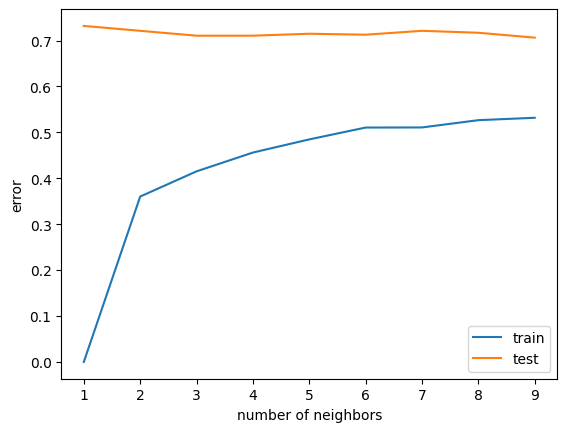

In [63]:
KNN_Classifier(df)

In [65]:
def scores_KNN_Classifier(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)    
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(X_train, Y_train)
    Y_pred_neigh_test = neigh.predict(X_test)
    print(confusion_matrix(Y_test, Y_pred_neigh_test, labels=[0,1,2,3]))
    print(classification_report(Y_test, Y_pred_neigh_test, digits = 4))

In [66]:
scores_KNN_Classifier(df)

[[31 32 31 23]
 [30 31 29 24]
 [32 26 26 32]
 [26 26 33 38]]
              precision    recall  f1-score   support

           0     0.2605    0.2650    0.2627       117
           1     0.2696    0.2719    0.2707       114
           2     0.2185    0.2241    0.2213       116
           3     0.3248    0.3089    0.3167       123

    accuracy                         0.2681       470
   macro avg     0.2683    0.2675    0.2678       470
weighted avg     0.2692    0.2681    0.2686       470



In [67]:
scores_KNN_Classifier(df1)

[[55 58 52 28]
 [66 62 53 35]
 [53 57 38 35]
 [35 34 47 78]]
              precision    recall  f1-score   support

           0     0.2632    0.2850    0.2736       193
           1     0.2938    0.2870    0.2904       216
           2     0.2000    0.2077    0.2038       183
           3     0.4432    0.4021    0.4216       194

    accuracy                         0.2964       786
   macro avg     0.3000    0.2954    0.2974       786
weighted avg     0.3013    0.2964    0.2985       786



In [68]:
def KNN_Classifier_bin(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    n_neighbors = [n for n in range(1,10)]
    test_scores = []
    train_scores = []

    for n in n_neighbors:
        neigh = KNeighborsClassifier(n_neighbors = n)
        neigh.fit(X_train, Y_bin_train)
        score_train = neigh.score(X_train, Y_bin_train)
        score_test = neigh.score(X_test, Y_bin_test)
        train_scores.append(1 - score_train)
        test_scores.append(1 - score_test)

    fig, ax = plt.subplots()
    ax.plot(n_neighbors, train_scores, label="train")
    ax.plot(n_neighbors, test_scores, label="test")
    ax.set_xlabel("number of neighbors")
    ax.set_ylabel("error")
    plt.legend()

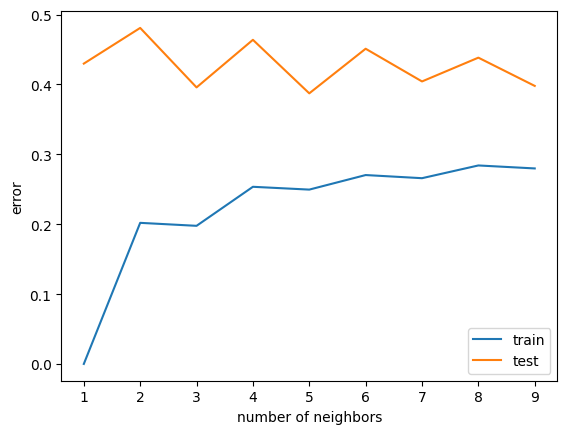

In [69]:
KNN_Classifier_bin(df)

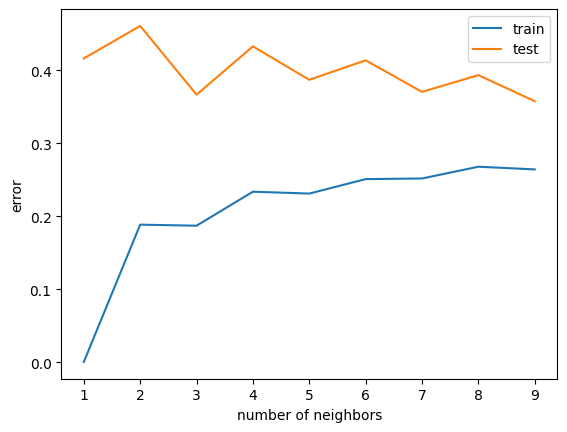

In [70]:
KNN_Classifier_bin(df1)

In [73]:
def scores_KNN_Classifier_bin(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)    
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(X_train, Y_bin_train)
    Y_pred_neigh_test = neigh.predict(X_test)
    print(confusion_matrix(Y_bin_test, Y_pred_neigh_test, labels=[0,1]))
    print(classification_report(Y_bin_test, Y_pred_neigh_test, digits = 4))

In [74]:
scores_KNN_Classifier_bin(df)

[[ 52  98]
 [104 216]]
              precision    recall  f1-score   support

           0     0.3333    0.3467    0.3399       150
           1     0.6879    0.6750    0.6814       320

    accuracy                         0.5702       470
   macro avg     0.5106    0.5108    0.5106       470
weighted avg     0.5747    0.5702    0.5724       470



In [75]:
scores_KNN_Classifier_bin(df1)

[[105 153]
 [174 354]]
              precision    recall  f1-score   support

           0     0.3763    0.4070    0.3911       258
           1     0.6982    0.6705    0.6841       528

    accuracy                         0.5840       786
   macro avg     0.5373    0.5387    0.5376       786
weighted avg     0.5926    0.5840    0.5879       786



### methode du Dummy Classifier

In [76]:
def Dummy_Classifier(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    Dum = DummyClassifier()
    Dum.fit(X_train, Y_train)
    test_score = Dum.score(X_test, Y_test)
    print(f'test_score = {test_score}')

In [77]:
Dummy_Classifier(df)

test_score = 0.2425531914893617


In [78]:
Dummy_Classifier(df1)  

test_score = 0.23282442748091603


### methode de la Logistic Regression

création d'un score binaire pour les tranche de benefice globale sur df (0 : film à perte, 1 : film ayant un benefice global positif)

In [83]:
def Grid_search_logistic_regression(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)

    stds = preprocessing.StandardScaler()

    Z_train = stds.fit_transform(X_train)

    logit = LogisticRegression()

    parameters = [{'penalty':['l1','l2']}, 
                {'C':[1, 10, 100, 1000]}]

    grid_search = GridSearchCV(estimator = logit,  
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            verbose=0)

    grid_search.fit(Z_train, Y_bin_train)

    return grid_search

def print_Grid_search(df):

    grid_search = Grid_search_logistic_regression(df)
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

    # print estimator that was chosen by the GridSearch
    print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

In [84]:
print_Grid_search(df)

GridSearch CV best score : 0.6779


Parameters that give the best results : 

 {'C': 10}


Estimator that was chosen by the search : 

 LogisticRegression(C=10)


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages

In [85]:
print_Grid_search(df1)

GridSearch CV best score : 0.6818


Parameters that give the best results : 

 {'penalty': 'l2'}


Estimator that was chosen by the search : 

 LogisticRegression()


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages

In [82]:
def OR_logistic_regression(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    logit = LogisticRegression(C=10, max_iter = 60)

    stds = preprocessing.StandardScaler()

    Z_train = stds.fit_transform(X_train)

    #Starting calculations and no need to add the constant
    logit.fit(Z_train,Y_bin_train)

    # computing OR
    print(pd.DataFrame({"var":X_train.columns,"coef":logit.coef_[0], "OR":np.exp(logit.coef_[0])}))

In [86]:
OR_logistic_regression(df)

                     var      coef        OR
0                 budget -0.081646  0.921599
1                  duree  0.340255  1.405306
2                  suite  0.567548  1.763937
3                 Comedy  0.117450  1.124625
4                  Drama -0.103880  0.901334
5                 Horror  0.186626  1.205177
6               Thriller -0.008230  0.991804
7                 Action  0.065589  1.067788
8              Adventure -0.031417  0.969072
9        Science Fiction -0.047131  0.953963
10               Fantasy -0.013765  0.986330
11                Family  0.171836  1.187483
12                 Crime  0.002889  1.002893
13               Romance  0.057545  1.059233
14             Animation  0.019849  1.020047
15               Mystery  0.027740  1.028128
16                   War -0.043570  0.957365
17                 Music -0.025615  0.974711
18               Western -0.073668  0.928980
19               History -0.098073  0.906582
20           Documentary  0.118598  1.125917
21        

In [88]:
OR_logistic_regression(df1)

                     var      coef        OR
0                 budget -0.282032  0.754250
1                  duree  0.283691  1.328023
2                  suite  0.491728  1.635139
3                 Comedy  0.033073  1.033626
4                  Drama -0.072176  0.930368
5                 Horror  0.102683  1.108140
6               Thriller -0.047386  0.953719
7                 Action  0.024705  1.025012
8              Adventure  0.023295  1.023568
9        Science Fiction -0.015515  0.984605
10               Fantasy -0.023923  0.976360
11                Family  0.095678  1.100405
12                 Crime  0.059842  1.061669
13               Romance  0.111562  1.118023
14             Animation -0.037322  0.963366
15               Mystery -0.011885  0.988185
16                   War  0.024935  1.025248
17                 Music  0.020966  1.021187
18               Western  0.012911  1.012995
19               History -0.081625  0.921618
20           Documentary  0.057004  1.058660
21        

In [98]:
def scores_logistic_regression(df):
    
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    stds = preprocessing.StandardScaler()
    Z_train = stds.fit_transform(X_train)
    Z_test = stds.fit_transform(X_test)
    logit = LogisticRegression(C=10, max_iter = 60)
    logit.fit(Z_train,Y_bin_train)
    predlog_test = logit.predict(Z_test)
    print(confusion_matrix(Y_bin_test, predlog_test, labels=[0,1]))
    print(classification_report(Y_bin_test, predlog_test))

    scores = cross_val_score(logit, Z_train, Y_bin_train, cv = 5, scoring='accuracy')

    print('Cross-validation scores:{}'.format(scores))
    print('Average cross-validation score: {:.4f}'.format(scores.mean()))
    print('Average cross-validation score: {:.4f}'.format(scores.std()))

In [99]:
scores_logistic_regression(df)

[[ 21 129]
 [ 16 304]]
              precision    recall  f1-score   support

           0       0.57      0.14      0.22       150
           1       0.70      0.95      0.81       320

    accuracy                           0.69       470
   macro avg       0.63      0.54      0.52       470
weighted avg       0.66      0.69      0.62       470

Cross-validation scores:[0.67810651 0.67100592 0.67692308 0.67573964 0.68757396]
Average cross-validation score: 0.6779
Average cross-validation score: 0.0054


In [100]:
scores_logistic_regression(df1)

[[ 46 212]
 [ 32 496]]
              precision    recall  f1-score   support

           0       0.59      0.18      0.27       258
           1       0.70      0.94      0.80       528

    accuracy                           0.69       786
   macro avg       0.65      0.56      0.54       786
weighted avg       0.66      0.69      0.63       786

Cross-validation scores:[0.68175389 0.68811881 0.68458274 0.67609618 0.67751061]
Average cross-validation score: 0.6816
Average cross-validation score: 0.0044


### Méthode SVM

In [105]:
def SVM(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    clf = svm.SVC()
    stds = preprocessing.StandardScaler()
    Z_train = stds.fit_transform(X_train)
    Z_test = stds.transform(X_test)
    clf.fit(Z_train, Y_train)
    Y_pred = clf.predict(Z_test)
    print(confusion_matrix(Y_test, Y_pred, labels=[0,1,2,3]))
    print(classification_report(Y_test, Y_pred, digits=4))

In [106]:
SVM(df)

[[72 21  5 19]
 [48 26 17 23]
 [29 26 32 29]
 [30 20 24 49]]
              precision    recall  f1-score   support

           0     0.4022    0.6154    0.4865       117
           1     0.2796    0.2281    0.2512       114
           2     0.4103    0.2759    0.3299       116
           3     0.4083    0.3984    0.4033       123

    accuracy                         0.3809       470
   macro avg     0.3751    0.3794    0.3677       470
weighted avg     0.3761    0.3809    0.3690       470



In [107]:
SVM(df1)

[[ 95  32  15  51]
 [ 64  57  37  58]
 [ 43  15  56  69]
 [ 35  14  24 121]]
              precision    recall  f1-score   support

           0     0.4008    0.4922    0.4419       193
           1     0.4831    0.2639    0.3413       216
           2     0.4242    0.3060    0.3556       183
           3     0.4047    0.6237    0.4909       194

    accuracy                         0.4186       786
   macro avg     0.4282    0.4215    0.4074       786
weighted avg     0.4298    0.4186    0.4062       786



In [109]:
def SVM_bin(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    clf = svm.SVC()
    stds = preprocessing.StandardScaler()
    Z_train = stds.fit_transform(X_train)
    Z_test = stds.transform(X_test)
    clf.fit(Z_train, Y_bin_train)
    Y_pred = clf.predict(Z_test)
    print(confusion_matrix(Y_bin_test, Y_pred, labels=[0,1]))
    print(classification_report(Y_bin_test, Y_pred, digits=4))

In [110]:
SVM_bin(df)

[[ 18 132]
 [ 10 310]]
              precision    recall  f1-score   support

           0     0.6429    0.1200    0.2022       150
           1     0.7014    0.9688    0.8136       320

    accuracy                         0.6979       470
   macro avg     0.6721    0.5444    0.5079       470
weighted avg     0.6827    0.6979    0.6185       470



In [111]:
SVM_bin(df1)

[[ 20 238]
 [ 21 507]]
              precision    recall  f1-score   support

           0     0.4878    0.0775    0.1338       258
           1     0.6805    0.9602    0.7965       528

    accuracy                         0.6705       786
   macro avg     0.5842    0.5189    0.4652       786
weighted avg     0.6173    0.6705    0.5790       786

